In [66]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, scale
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, roc_curve, roc_auc_score

In [38]:
#Haremos regresión logística para predecir la compra con los features dados
#Este es un data set muy limpio, todas las variables son numericas salvo el genero
suv_data = pd.read_csv("datasets_17233_22624_Social_Network_Ads.csv")
suv_data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [89]:
#Make the dataset more fit for the logit model by changing categorical variables into numeric
#with one-hot encoding
def processing(df):
    cat_df = df.select_dtypes(include = [object])
    cat_cols = cat_df.columns
    
    oh_enc = OneHotEncoder()
    labels = pd.DataFrame(oh_enc.fit_transform(cat_df).toarray())
    labels.columns = oh_enc.get_feature_names(cat_cols)
    X = df.drop(cat_cols, axis = 1).join(labels)
    return X
X = processing(suv_data)

In [88]:
X

,User ID,Age,EstimatedSalary,Purchased,Gender_Female,Gender_Male
0,15624510,19,19000,0,0.0,1.0
1,15810944,35,20000,0,0.0,1.0
2,15668575,26,43000,0,1.0,0.0
3,15603246,27,57000,0,1.0,0.0
4,15804002,19,76000,0,0.0,1.0
...,...,...,...,...,...,...
395,15691863,46,41000,1,1.0,0.0
396,15706071,51,23000,1,0.0,1.0
397,15654296,50,20000,1,1.0,0.0
398,15755018,36,33000,0,0.0,1.0


In [90]:
#We split the data into 70% training, 30% validation
train, test = train_test_split(X, test_size = 0.3, random_state = 1)
y_train = train['Purchased']

In [91]:
#variable & target
X_train = train.drop(['Purchased'], axis = 1)
X_train, y_train

(      User ID  Age  EstimatedSalary  Gender_Female  Gender_Male
 39   15782806   27            31000            1.0          0.0
 167  15614827   35            71000            1.0          0.0
 383  15707634   49            28000            0.0          1.0
 221  15663161   35            91000            0.0          1.0
 351  15591279   37            75000            0.0          1.0
 ..        ...  ...              ...            ...          ...
 255  15750056   52            90000            1.0          0.0
 72   15595228   20            23000            1.0          0.0
 396  15706071   51            23000            0.0          1.0
 235  15646227   46            79000            0.0          1.0
 37   15689425   30            49000            0.0          1.0
 
 [280 rows x 5 columns], 39     0
 167    0
 383    1
 221    1
 351    0
       ..
 255    1
 72     0
 396    1
 235    1
 37     0
 Name: Purchased, Length: 280, dtype: int64)

In [8]:
#We create and fit the logit model
log_reg = LogisticRegression(solver = 'lbfgs')
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
#getting the mean absolute error 
X_test = test.drop(['Purchased'], axis = 1)
y_test = test['Purchased']
y_pred_test = log_reg.predict(X_test)

print(mean_absolute_error(y_test, y_pred_test))

0.30833333333333335


AUC score: 0.6458333333333334


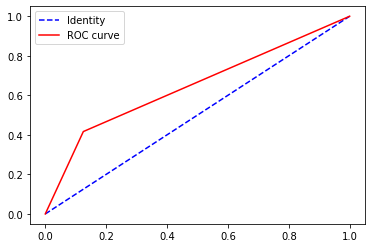

In [95]:
#Plottting the ROC curve and printing the AUC score
def get_roc_score(y, y_pred):
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    plt.plot([0,1],[0,1],'b--' ,label = 'Identity')
    plt.plot(fpr, tpr, 'r' ,label = 'ROC curve' )
    plt.legend()
    print("AUC score: "+str(roc_auc_score(y, y_pred)))
get_roc_score(y_test, y_pred_test)

In [10]:
#Now let's do some feature selection using chi^2 test
from sklearn.feature_selection import SelectKBest, chi2

Variables utilizadas: 
EstimatedSalary

AUC score: 0.5
0.4 1 variables 

Variables utilizadas: 
Age
EstimatedSalary

AUC score: 0.5
0.4 2 variables 

Variables utilizadas: 
User ID
Age
EstimatedSalary

AUC score: 0.6458333333333334
0.30833333333333335 3 variables 

Variables utilizadas: 
User ID
Age
EstimatedSalary
Gender_Male

AUC score: 0.6458333333333334
0.30833333333333335 4 variables 

Variables utilizadas: 
User ID
Age
EstimatedSalary
Gender_Female
Gender_Male

AUC score: 0.6458333333333334
0.30833333333333335 5 variables 



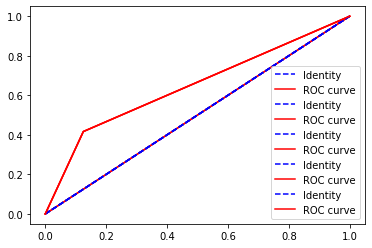

In [96]:
for i in range(1,6):
    selector = SelectKBest(chi2, k = i).fit(X_train, y_train)
    mask = selector.get_support()
    print("Variables utilizadas: ")
    for boolean, feat in zip(mask, X_train):
        if boolean:
            print(feat)
    X_train_f = selector.transform(X_train)
    log_reg2 = LogisticRegression(solver = 'lbfgs')
    log_reg2.fit(X_train_f, y_train)
    X_test_f = selector.transform(X_test)
    y_f_pred = log_reg2.predict(X_test_f)
    print()
    get_roc_score(y_test, y_f_pred)
    print(mean_absolute_error(y_f_pred, y_test), str(i)+" variables \n")


Some key things to notice, the logistic regression is not that good! The best we can do is a 64% AUC score and a 30% mean absolute error. Can we improve our model? We'll attempt now using linear discriminant analysis.

In [92]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Creating and fitting the model
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

/home/a_garval/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

Note: The warning above is due to the obvious fact that the columns "male" and "female" are _very_ correlated. We take care of the warning with a $\chi^2$ selector later.

0.175
AUC score: 0.8055555555555556


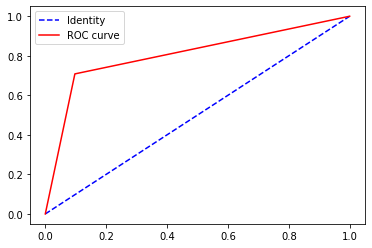

In [97]:
y_ld = clf.predict(X_test)
print(mean_absolute_error(y_test, y_ld))
get_roc_score(y_test, y_ld)

As we can see, we got a much better ROC curve and a much better AUC score. The mean absolute error is much smaller (10%). Even so, can we improve with feature selection?

Variables utilizadas: 
EstimatedSalary

AUC score: 0.6458333333333334
0.30833333333333335 1 variables 

Variables utilizadas: 
Age
EstimatedSalary

AUC score: 0.8055555555555556
0.175 2 variables 

Variables utilizadas: 
User ID
Age
EstimatedSalary

AUC score: 0.8055555555555556
0.175 3 variables 

Variables utilizadas: 
User ID
Age
EstimatedSalary
Gender_Male

AUC score: 0.8055555555555556
0.175 4 variables 



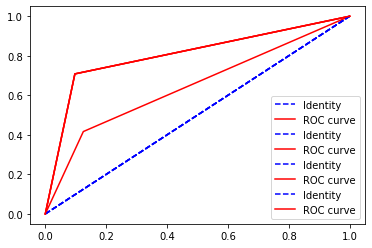

In [100]:
for i in range(1,5):
    selector = SelectKBest(chi2, k = i).fit(X_train, y_train)
    mask = selector.get_support()
    print("Variables utilizadas: ")
    for boolean, feat in zip(mask, X_train):
        if boolean:
            print(feat)
    X_train_f = selector.transform(X_train)
    X_test_f = selector.transform(X_test)
    
    clf_2 = LinearDiscriminantAnalysis()
    clf_2.fit(X_train_f, y_train)
    X_test_f = selector.transform(X_test)
    y_f_pred = clf_2.predict(X_test_f)
    print()
    get_roc_score(y_test, y_f_pred)
    print(mean_absolute_error(y_f_pred, y_test), str(i)+" variables \n")

As we can see, we can do better predictions with linear discriminant analysis instead of the logistic regression. However, it's good to know how to do logit regression and to check by ourselves which method is better.